In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from src.models.autoencoder import build_autoencoder
from src.data_loader import build_test_dataset, get_test_paths

In [3]:
category = "bottle"

test_path, test_labels = get_test_paths(category=category)
test_ds = build_test_dataset(test_path, test_labels)

In [6]:

WEIGHTS_DIR = PROJECT_ROOT / "weights"
WEIGHTS_DIR.mkdir(exist_ok=True)

autoencoder.save(WEIGHTS_DIR / "autoencoder_bottle_baseline.keras")

In [7]:
autoencoder = build_autoencoder(input_shape=(256, 256, 3))

In [9]:
autoencoder.save("../weights/autoencoder_bottle_baseline.keras")

In [10]:
autoencoder = tf.keras.models.load_model(
    PROJECT_ROOT / "weights" / "autoencoder_bottle_baseline.keras"
)


In [11]:
recon_errors = []

for batch_x, batch_y in test_ds:
    recon = autoencoder(batch_x, training = False)
    err = tf.reduce_mean(
        tf.math.squared_difference(batch_x, recon),
        axis = [1, 2, 3]
    )
    recon_errors.extend(err.numpy())
recon_errors = np.array(recon_errors)
test_labels = np.array(test_labels)

2026-01-06 22:13:07.752313: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
len(recon_errors), len(test_labels)

(83, 83)

In [13]:
recon_errors[:5]

array([0.12729694, 0.12896611, 0.12660599, 0.12846762, 0.1308145 ],
      dtype=float32)

In [14]:
from sklearn.metrics import roc_auc_score
roc = roc_auc_score(test_labels, recon_errors)
print("ROC-AUC score", roc)

ROC-AUC score 0.292063492063492


In [20]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_labels, -recon_errors)

In [21]:
print("Good mean:", np.mean(recon_errors[test_labels == 0]))
print("Anomaly mean:", np.mean(recon_errors[test_labels == 1]))

Good mean: 0.13000785
Anomaly mean: 0.1283613


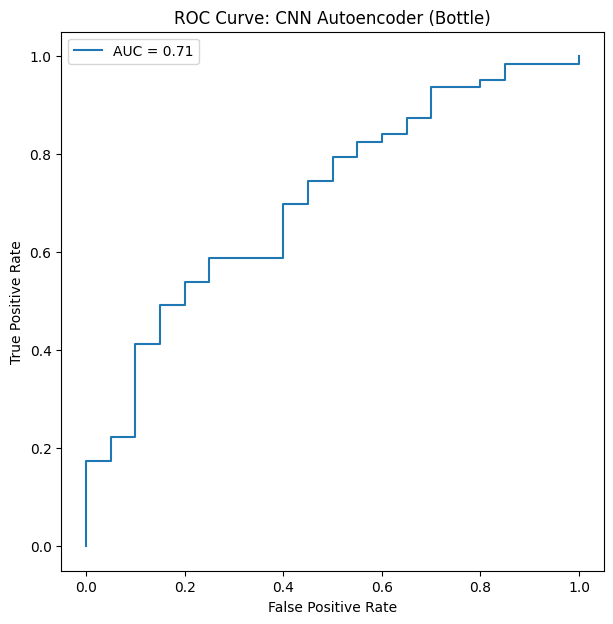

In [22]:
from sklearn.metrics import roc_curve
score = - recon_errors
fpr, tpr, _ =roc_curve(test_labels, score)
plt.figure(figsize = (7,7))
plt.plot(fpr, tpr, label = f"AUC = {auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: CNN Autoencoder (Bottle)")
plt.legend()
plt.show()

In [23]:
import seaborn as sns

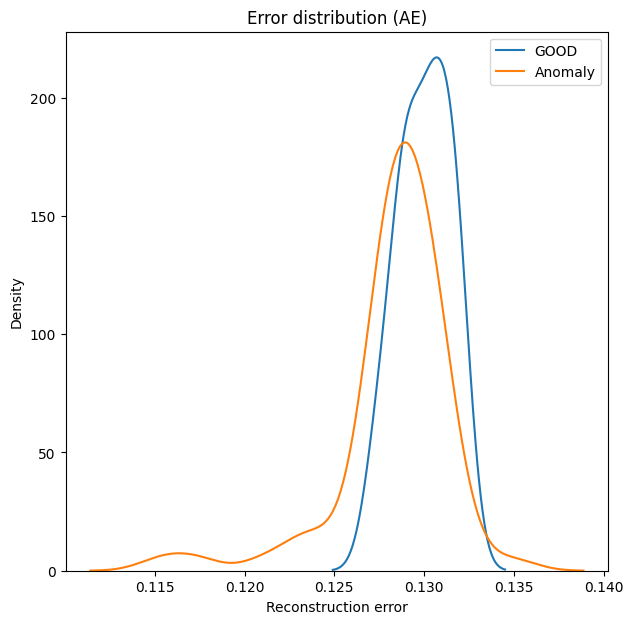

In [24]:
plt.figure(figsize=(7,7))
sns.kdeplot(recon_errors[test_labels == 0], label = "GOOD")
sns.kdeplot(recon_errors[test_labels == 1], label="Anomaly")
plt.xlabel("Reconstruction error")
plt.title("Error distribution (AE)")
plt.legend()
plt.show()